In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")

from electronfactors.model.utilities import *

In [2]:
width, length, eqPonA, factor = pull_data(energy=12)

In [3]:
x = np.array([])
y = np.array([])

In [4]:
## Edit the default functions with the purpose of checking smaller model against full data set

def calculate_percent_prediction_differences(width, eqPonA, factor, reference):
    
    check = np.setdiff1d(np.arange(len(width)), reference)
    give = np.zeros(len(check))
    gap = np.zeros(len(check))
    
    predictions = np.zeros(len(check))

    bbox = [np.min(width), np.max(width),
            np.min(eqPonA), np.max(eqPonA)]
    
    model = create_model(width[reference], eqPonA[reference], factor[reference], bbox=bbox)
    
    for i, value in enumerate(check):
        predictions[i] = model(width[value], eqPonA[value])
        give[i] = fit_give(
            width[value], eqPonA[value], 
            width[reference], eqPonA[reference], factor[reference])

    percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

    invalid = give > 0.5
    percent_prediction_differences = percent_prediction_differences[~invalid]

    return percent_prediction_differences


def prediction_uncertainty(width, eqPonA, factor, reference):

    percent_prediction_differences = calculate_percent_prediction_differences(
        width, eqPonA, factor, reference)

    if len(percent_prediction_differences) > 1:
        prediction_uncertainty = (
            np.std(percent_prediction_differences, ddof=1) /
            c4(len(percent_prediction_differences)))
        total = (
            prediction_uncertainty +
            np.abs(np.mean(percent_prediction_differences)))
    else:
        total = np.nan

    return total

In [12]:
def data_reduction_loop(x, y, width, eqPonA, factor, n=1000):
    for amount in np.arange(7, np.floor(len(width)/2) + 1):        
        order = np.arange(len(width))
        np.random.shuffle(order)
        
        reference = order[0:amount]
        uncertainty = prediction_uncertainty(width, eqPonA, factor, reference)
        
        if uncertainty is not(np.nan):
            x = np.append(x, amount)
            y = np.append(y, uncertainty)    
    
    for i in range(n):
        bin_mid = np.arange(np.min(x), np.max(x) + 1)
        bins = np.linspace(np.min(x)-0.5, np.max(x)+0.5, np.ptp(x)+2)
        histogrammed, value = np.histogram(x, bins=bins)
        amount = bin_mid[np.argmin(histogrammed)]
        
        order = np.arange(len(width))
        np.random.shuffle(order)
        
        reference = order[0:amount]
        uncertainty = prediction_uncertainty(width, eqPonA, factor, reference)
        
        if uncertainty is not(np.nan):
            x = np.append(x, amount)
            y = np.append(y, uncertainty)
    
    return x, y        

In [18]:
def plot_intervals(x, y):
    amounts = np.arange(11, np.max(x) + 1)

    upper_interval_3 = np.zeros(len(amounts))
    upper_interval_2 = np.zeros(len(amounts))
    upper_interval_1 = np.zeros(len(amounts))

    lower_interval_1 = np.zeros(len(amounts))
    lower_interval_2 = np.zeros(len(amounts))
    lower_interval_3 = np.zeros(len(amounts))
    
    for i, amount in enumerate(amounts):    
        reference = (x == amount)
        n = np.sum(reference)

        upper_interval_position_3 = np.ceil(n * 0.9985) - 1
        upper_interval_position_2 = np.ceil(n * 0.975) - 1
        upper_interval_position_1 = np.ceil(n * 0.84) - 1

        lower_interval_position_1 = np.floor(n * 0.16) - 1
        lower_interval_position_2 = np.floor(n * 0.025) - 1
        lower_interval_position_3 = np.floor(n * 0.0015) - 1    

        uncertainties_sorted = np.sort(y[reference])

        upper_interval_3[i] = uncertainties_sorted[upper_interval_position_3]
        upper_interval_2[i] = uncertainties_sorted[upper_interval_position_2]
        upper_interval_1[i] = uncertainties_sorted[upper_interval_position_1]

        lower_interval_1[i] = uncertainties_sorted[lower_interval_position_1]
        lower_interval_2[i] = uncertainties_sorted[lower_interval_position_2]
        lower_interval_3[i] = uncertainties_sorted[lower_interval_position_3]
    
    plt.plot(
        amounts, upper_interval_1, 'r-',
        amounts, upper_interval_2, 'r--',
        amounts, upper_interval_3, 'k--',
        amounts, lower_interval_1, 'r-',
        amounts, lower_interval_2, 'r--',
        amounts, lower_interval_3, 'k--',
    )

In [24]:
x, y = data_reduction_loop(x, y, width, eqPonA, factor, n=100000)

Number of data sets used = 134453


array([7470, 7470, 7470, 7470, 7470, 7470, 7470, 7470, 7470, 7470, 7470,
       7469, 7469, 7469, 7469, 7469, 7469, 7469])

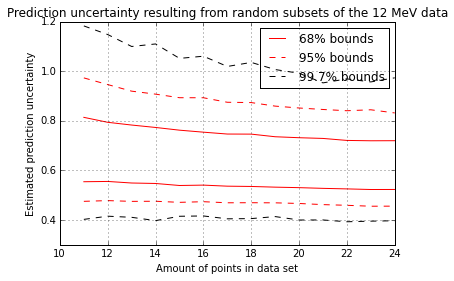

In [25]:
plot_intervals(x, y)
plt.grid(True)

plt.xlabel("Amount of points in data set")
plt.ylabel("Estimated prediction uncertainty")
plt.title("Prediction uncertainty resulting from random subsets of the 12 MeV data")
plt.legend(["68% bounds", "95% bounds", "99.7% bounds"])

print("Number of data sets used = %d" %(len(x)))

bins = np.linspace(np.min(x)-0.5, np.max(x)+0.5, np.ptp(x)+2)
histogrammed, value = np.histogram(x, bins=bins)
histogrammed
